# Exploration4

In [13]:
import pandas
import konlpy
import gensim
from tensorflow import keras

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [29]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 1) 데이터 준비와 확인

In [30]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [31]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [32]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [33]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [34]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 가장 마지막 위치의 단어가 state에 가장 많은 영향을 미치므로 padding은 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [35]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


## 모델 구성

In [36]:
vocab_size = 10000
word_vector_dim = 200

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
______________________

# 5) 모델 훈련 개시

In [37]:
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
              
epochs = 3

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 1-D CNN과 동일하게 3 epochs로 진행
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 3s 8ms/step - loss: 0.4542 - accuracy: 0.7990 - val_loss: 0.3509 - val_accuracy: 0.8492
Epoch 2/5
247/247 [==============================] - 2s 6ms/step - loss: 0.3233 - accuracy: 0.8641 - val_loss: 0.3366 - val_accuracy: 0.8551
Epoch 3/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2911 - accuracy: 0.8778 - val_loss: 0.3351 - val_accuracy: 0.8576
Epoch 4/5
247/247 [==============================] - 2s 6ms/step - loss: 0.2651 - accuracy: 0.8891 - val_loss: 0.3457 - val_accuracy: 0.8555
Epoch 5/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2409 - accuracy: 0.8997 - val_loss: 0.3571 - val_accuracy: 0.8552
Epoch 1/3
247/247 [==============================] - 2s 7ms/step - loss: 0.4387 - accuracy: 0.7942 - val_loss: 0.3379 - val_accuracy: 0.8515
Epoch 2/3
247/247 [==============================] - 2s 6ms/step - loss: 0.3007 - accuracy: 0.8737 - val_loss: 0.3258 - val_accuracy: 0.8576
Epoch 3/3
247

# 6) Loss, Accuracy 그래프 시각화

## LMTM

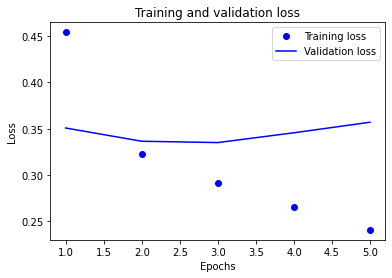

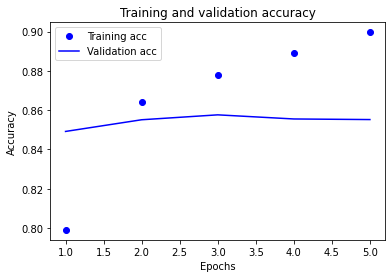

In [38]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [39]:
import os

embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]

In [ ]:
import pprint

path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("배우")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생

In [ ]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

## 모델에 적용

In [ ]:
vocab_size = 10000
word_vector_dim = 200 #https://github.com/Kyubyong/wordvectors 참고. 한국어 word2vec는 벡터 사이즈가 200이다.

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling1D layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

## 모델 훈련

In [ ]:
epochs = 4

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                    
epochs = 8

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

## 모델 평가

In [ ]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# one GlobalAveragePooling1D layer
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

# 회고

텍스트 분석을 통해 리뷰가 긍정인지 부정인지를 분류하는 모델을 만드는 것이 목표였다.

처음엔 학습된 워드 벡터를 적용하지 않고, 모델을 구성했다.

정확도는 LSTM과 MaxPooling1D 레이어를 하나만 사용해 구성한 모델이 84 퍼센트 대였고, 1-D CNN이 유일하게 85 퍼센트를 넘었다.

정확도는 목표로 한 85 퍼센트에 근접하거나 넘었지만, 학습한 벡터들을 확인하기 위해 각각의 모델이 내놓은 벡터 값 중 "배우"라는 단어의 벡터 값과 가장 유사한 벡터 값을 출력해보니, 세 모델 모두 전체적으로 "배우"와 유사하다고 할 수 있는 단어를 반환하지 못했다.

그래서 학습된 워드 임베딩을 적용한 모델을 테스트해봤다. (https://github.com/Kyubyong/wordvectors 에서 다운로드 받을 수 있다.)

한국어 Word2Vec 파일을 읽어오고, "배우"와 유사한 값을 갖는 벡터들을 출력해보니, "영화배우", "연출가", "연극배우" 등 전반적으로 자체 워드 임베딩의 벡터보다 유사한 단어를 출력하는 걸 확인할 수 있었다.

이 벡터값들을 각 모델의 임베딩 레이어에 적용하고 학습과 평가를 해보니 생각과는 다른 결과가 나왔다.

같은 조건에서 오히려 테스트 정확도가 낮게 나왔고, 모델들의 hyperparameter값을 조정한 후에야 LSTM 모델만 85 퍼센트를 넘었다.

올바른 추론인지는 모르곘지만, 첫 번째 epoch부터 training accuracy와 validation accuracy가 높게 나오고, 2~3번쨰 epoch부터는 training accuracy만 오르고 validation accuracy는 오히려 떨어지는 경향을 보이길래 처음부터 빠르게 학습 데이터에 과적합되는 것인지 궁금해서 1-D CNN 모델에 Dropout 레이어를 추가했더니 1-D CNN 모델도 85 퍼센트를 넘었다.

하지만 GlobalMaxPooling1D레이어와 GlobalAveragePooling1D레이어 하나만 적용한 모델은 85 퍼센트의 벽을 넘지 못했다.